<a href="https://colab.research.google.com/github/keripikkaneboo/Machine-Learning/blob/main/UTS/Clustering%20Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!gdown --id 1HIJVXKQwABrxDVoKj3eMTCmQ7T8LinF8

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1HIJVXKQwABrxDVoKj3eMTCmQ7T8LinF8
To: /content/UTSClustering.csv
100% 45.6M/45.6M [00:00<00:00, 54.2MB/s]


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

import time
from tqdm.notebook import tqdm

# Untuk feature selection
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif
from sklearn.feature_selection import chi2, f_classif, SelectKBest, VarianceThreshold
from sklearn.ensemble import RandomForestClassifier

# Untuk feature engineering
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Untuk clustering
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering
from sklearn.mixture import GaussianMixture

# Untuk evaluasi
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Untuk visualisasi
import matplotlib.cm as cm

# Specify the encoding to 'latin-1' when reading the CSV file
df = pd.read_csv('/content/UTSClustering.csv', encoding='latin-1')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [3]:
df = df.drop_duplicates().copy()
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
#Select numeric features
features = df[['Quantity', 'UnitPrice', 'TotalPrice']].copy()
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34


In [4]:
# 2. Feature Selection
print("\n\n2. FEATURE SELECTION")
print("-" * 50)

# a. Constant-Quasi-Constant Features
print("a. Constant-Quasi-Constant Features")

# Select only numeric columns for variance threshold analysis
numeric_df = df.select_dtypes(include=[np.number])

constant_filter = VarianceThreshold(threshold=0.01)
constant_filter.fit(numeric_df)  # Fit on numeric data only

# Get constant columns from the numeric columns
constant_columns = [column for column in numeric_df.columns
                   if column not in numeric_df.columns[constant_filter.get_support()]]

print(f"Kolom dengan variance rendah (quasi-constant): {constant_columns}")
if len(constant_columns) > 0:
    df = df.drop(columns=constant_columns)  # Drop from the original df
    print(f"Menghapus {len(constant_columns)} kolom quasi-constant")



2. FEATURE SELECTION
--------------------------------------------------
a. Constant-Quasi-Constant Features
Kolom dengan variance rendah (quasi-constant): []


In [5]:
# b. Duplicate Features
print("\nb. Duplicate Features")
duplicate_cols = []
for i in range(len(df.columns)):
    for j in range(i+1, len(df.columns)):
        if df.iloc[:, i].equals(df.iloc[:, j]):
            duplicate_cols.append(df.columns[j])
print(f"Kolom duplikat: {duplicate_cols}")
if len(duplicate_cols) > 0:
    df = df.drop(columns=duplicate_cols)
    print(f"Menghapus {len(duplicate_cols)} kolom duplikat")


b. Duplicate Features
Kolom duplikat: []



c. Correlation Analysis


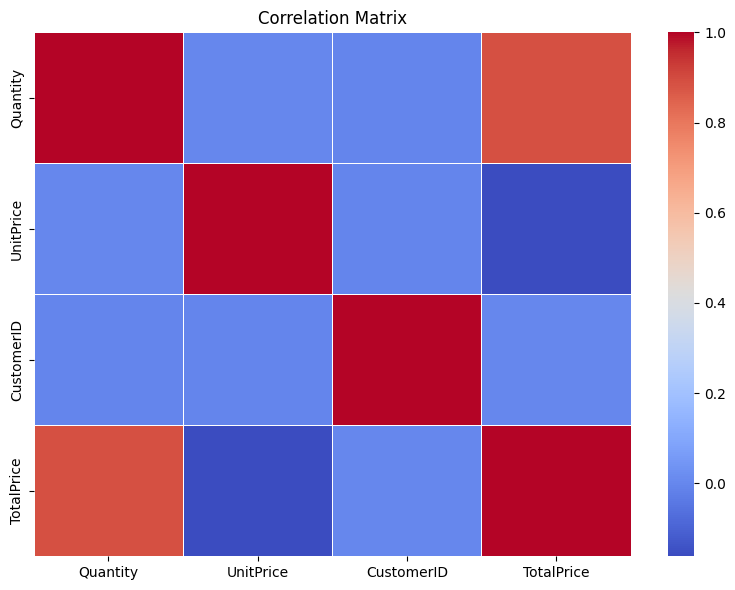

Fitur dengan korelasi tinggi (>0.8): {'TotalPrice'}
Menghapus 1 kolom dengan korelasi tinggi


In [6]:
# c. Correlation Analysis
print("\nc. Correlation Analysis")
numeric_df = df.select_dtypes(include=[np.number])
correlation_matrix = numeric_df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

# Hapus fitur dengan korelasi tinggi (>0.8)
high_corr_threshold = 0.8
high_corr_features = set()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > high_corr_threshold:
            colname = correlation_matrix.columns[i]
            high_corr_features.add(colname)

print(f"Fitur dengan korelasi tinggi (>0.8): {high_corr_features}")
if len(high_corr_features) > 0:
    df = df.drop(columns=list(high_corr_features))
    print(f"Menghapus {len(high_corr_features)} kolom dengan korelasi tinggi")


d. Mutual Information
Skor Mutual Information (terhadap label K-means sementara):
CustomerID: 1.0384
UnitPrice: 0.1487
Quantity: 0.0476


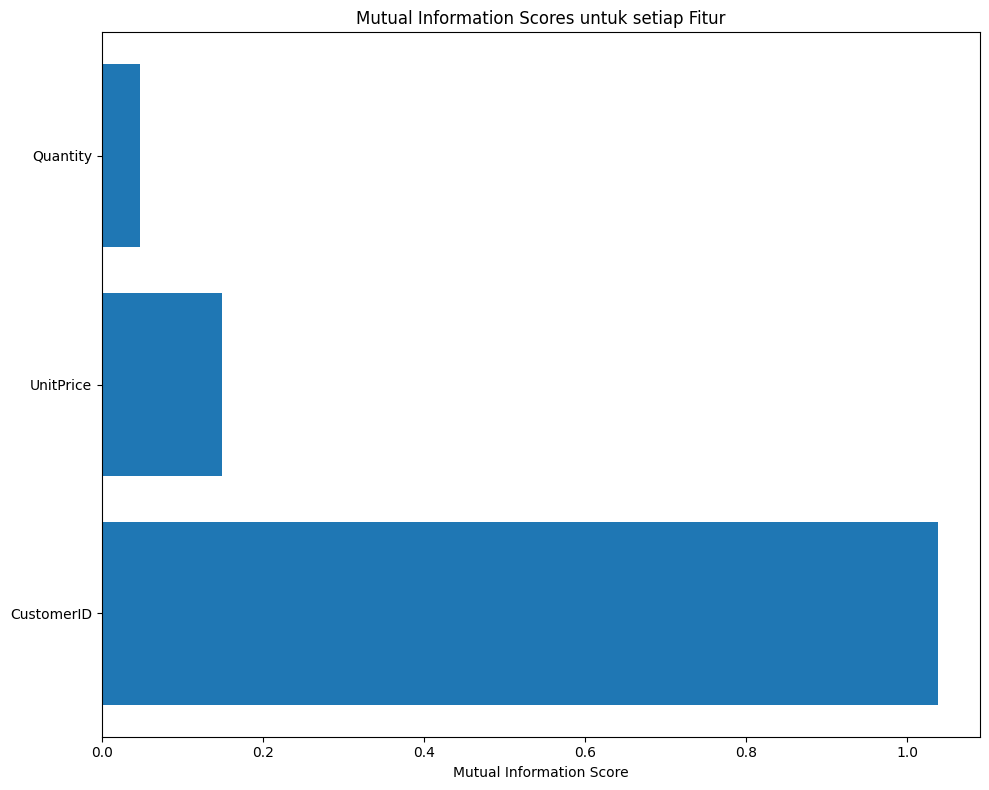


Fitur yang dipilih berdasarkan Mutual Information (>0.05): ['CustomerID', 'UnitPrice']


In [7]:
# d. Mutual Information
print("\nd. Mutual Information")
# Kita perlu membuat target dummy untuk mutual information
# Dalam kasus clustering, kita bisa menggunakan K-means sederhana untuk membuat label sementara
X = df.select_dtypes(include=[np.number])

# Impute missing values using the median before applying KMeans
# This ensures that the input data does not contain any NaN values
for col in X.columns:
    if X[col].isnull().any():
        X[col].fillna(X[col].median(), inplace=True)

temp_kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
temp_labels = temp_kmeans.fit_predict(X)

# Hitung mutual information
mi_scores = []
for col in X.columns:
    mi = mutual_info_classif(X[[col]], temp_labels, random_state=42)[0]
    mi_scores.append((col, mi))

mi_scores.sort(key=lambda x: x[1], reverse=True)
print("Skor Mutual Information (terhadap label K-means sementara):")
for feature, score in mi_scores:
    print(f"{feature}: {score:.4f}")

# Visualisasi MI Scores
plt.figure(figsize=(10, 8))
features, scores = zip(*mi_scores)
plt.barh(features, scores)
plt.xlabel('Mutual Information Score')
plt.title('Mutual Information Scores untuk setiap Fitur')
plt.tight_layout()
plt.show()

# Pilih fitur berdasarkan MI score
mi_threshold = 0.05  # Sesuaikan dengan kebutuhan
selected_features_mi = [feature for feature, score in mi_scores if score > mi_threshold]
print(f"\nFitur yang dipilih berdasarkan Mutual Information (>{mi_threshold}): {selected_features_mi}")

In [9]:
# 3. Feature Engineering
print("\n\n3. FEATURE ENGINEERING")
print("-" * 50)

# a. Standardisasi
print("a. Standardisasi")
X = df[selected_features_mi].copy()  # Menggunakan fitur terpilih dari MI
print(f"Data shape sebelum feature engineering: {X.shape}")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

print("\nStatistik deskriptif setelah standardisasi:")
print(X_scaled_df.describe())




3. FEATURE ENGINEERING
--------------------------------------------------
a. Standardisasi
Data shape sebelum feature engineering: (536641, 2)

Statistik deskriptif setelah standardisasi:
         CustomerID     UnitPrice
count  4.016040e+05  5.366410e+05
mean   4.682175e-16 -7.811930e-19
std    1.000001e+00  1.000001e+00
min   -1.712459e+00 -1.138162e+02
25%   -7.830558e-01 -3.478916e-02
50%   -7.944020e-02 -2.625297e-02
75%    8.768003e-01 -5.169598e-03
max    1.753694e+00  4.007421e+02



b. PCA untuk dimensionality reduction


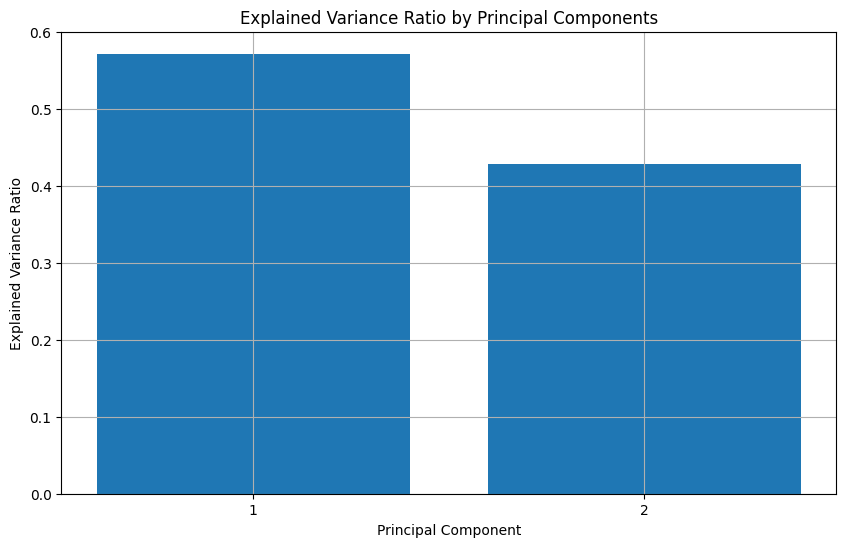

Cumulative explained variance: [0.57197596 1.        ]
Jumlah komponen yang menjelaskan 90% variance: 2
Data shape setelah PCA: (536641, 2)

Statistik deskriptif hasil PCA:
                PC1           PC2
count  5.366410e+05  5.366410e+05
mean   1.224752e-19  1.038060e-17
std    1.000013e+00  8.650689e-01
min   -1.138109e+02 -1.712735e+00
25%   -3.632822e-02 -5.337286e-01
50%   -2.288602e-02 -2.107167e-04
75%   -5.169357e-03  5.601029e-01
max    4.007245e+02  3.761249e+00


In [11]:
# b. PCA untuk dimensionality reduction (opsional)
print("\nb. PCA untuk dimensionality reduction")

# Impute NaN values in X_scaled before applying PCA
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)  # Convert to DataFrame
X_scaled_df.fillna(X_scaled_df.mean(), inplace=True)  # Impute NaNs with column means
X_scaled = X_scaled_df.values  # Convert back to NumPy array

pca = PCA(n_components=min(5, len(X.columns)))
X_pca = pca.fit_transform(X_scaled)

# Visualisasi explained variance ratio
plt.figure(figsize=(10, 6))
plt.bar(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio by Principal Components')
plt.xticks(range(1, pca.n_components_ + 1))
plt.grid(True)
plt.show()

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
print(f"Cumulative explained variance: {cumulative_variance}")

# Pilih jumlah komponen yang menjelaskan minimal 90% variance
n_components = np.argmax(cumulative_variance >= 0.9) + 1
print(f"Jumlah komponen yang menjelaskan 90% variance: {n_components}")

# Lakukan PCA lagi dengan jumlah komponen optimal
pca = PCA(n_components=max(2, n_components))  # Minimal 2 komponen untuk visualisasi
X_pca = pca.fit_transform(X_scaled)
print(f"Data shape setelah PCA: {X_pca.shape}")

# Dataframe untuk hasil PCA
pca_cols = [f'PC{i+1}' for i in range(X_pca.shape[1])]
X_pca_df = pd.DataFrame(X_pca, columns=pca_cols)

print("\nStatistik deskriptif hasil PCA:")
print(X_pca_df.describe())


In [13]:
# Clustering Models
from sklearn.exceptions import NotFittedError

# Assuming X_scaled contains the normalized features from previous steps
sample_data = pd.DataFrame(X_scaled).sample(n=2000, random_state=42).values

models = {
    "KMeans": KMeans(n_clusters=5, random_state=42),
    "Agglomerative": AgglomerativeClustering(n_clusters=5),
    "DBSCAN": DBSCAN(eps=0.5, min_samples=5),
    "GaussianMixture": GaussianMixture(n_components=5, random_state=42),
    "SpectralClustering": SpectralClustering(n_clusters=5, random_state=42, affinity='nearest_neighbors', n_neighbors=15)
}


cluster_labels = {}

for name, model in models.items():
    try:
        cluster_labels[name] = model.fit_predict(sample_data)
    except Exception as e:
        print(f"Model {name} gagal dijalankan: {e}")

In [16]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


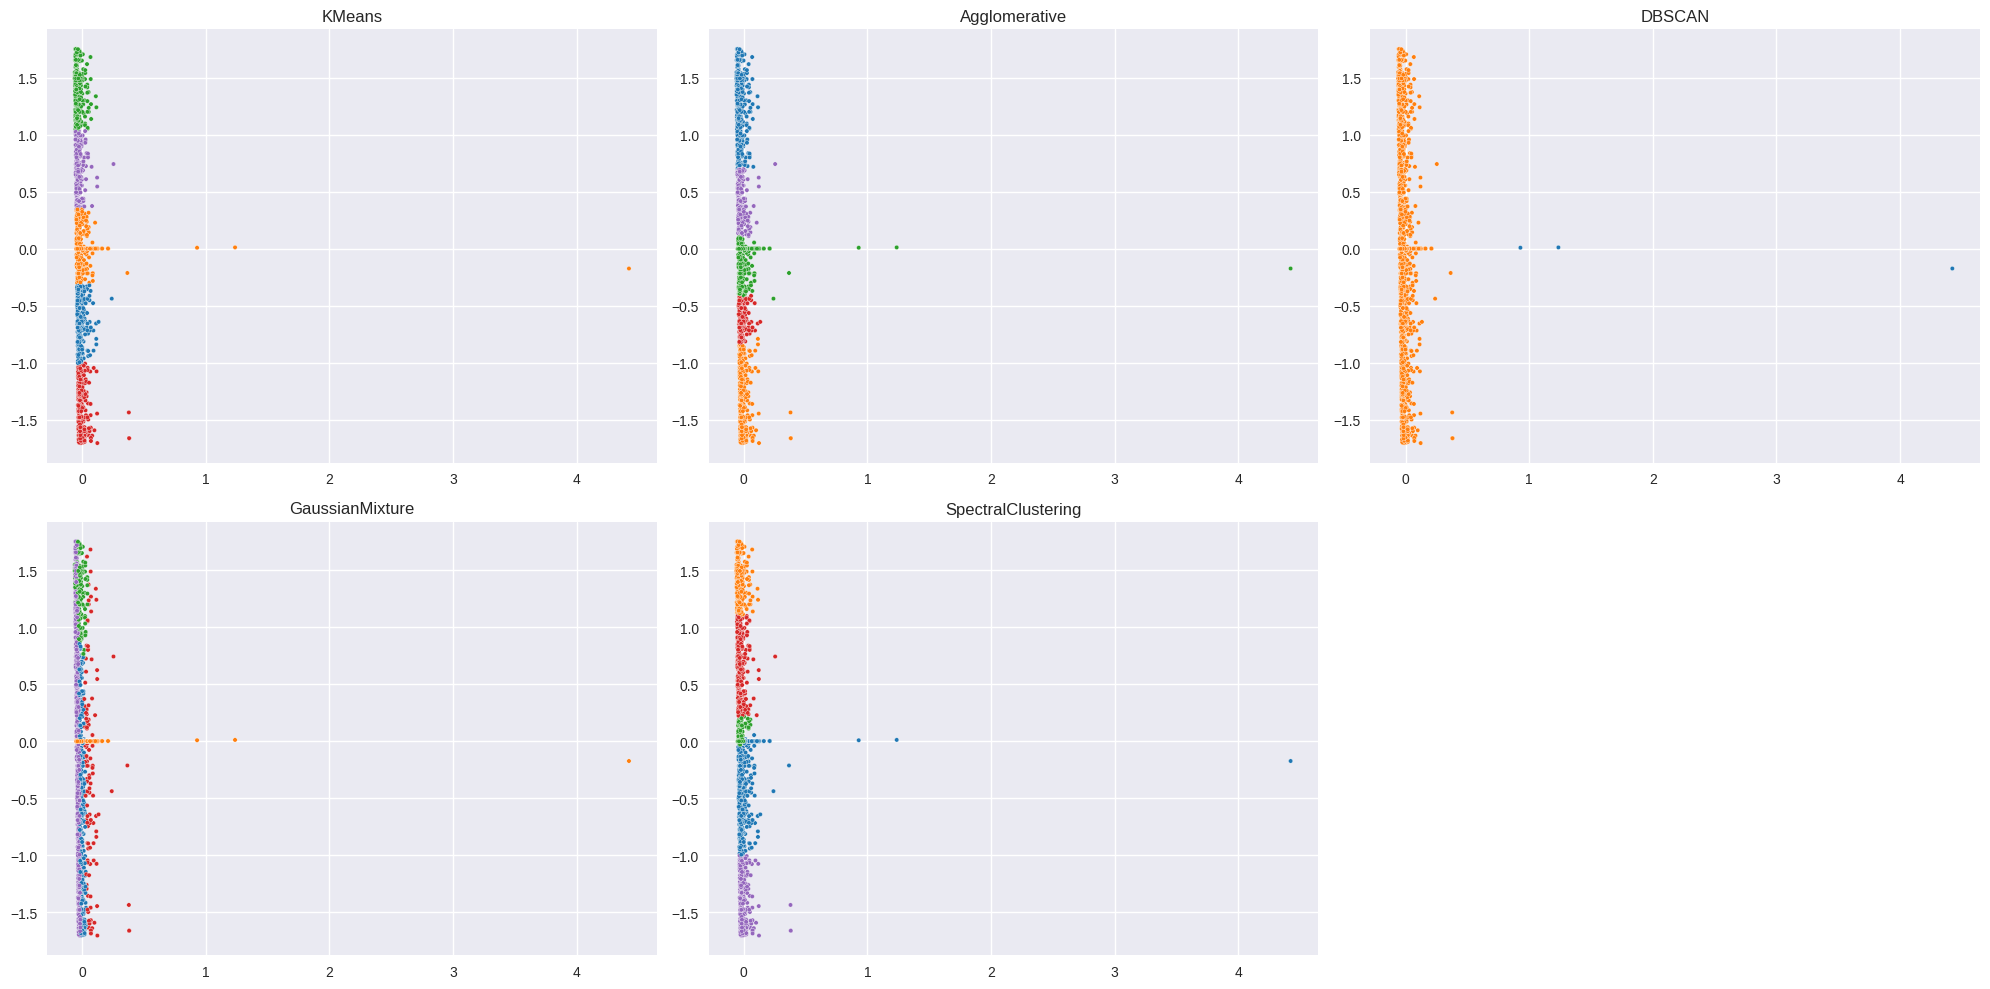

In [19]:
import matplotlib.gridspec as gridspec

plt.figure(figsize=(20, 10))
for i, (name, labels) in enumerate(cluster_labels.items()):
    subset = sample_data  # Semua model memakai sample_data yang sama
    pca_sub = pca.transform(subset)

    # Validasi panjang label dan data
    if len(labels) != len(pca_sub):
        print(f"⚠️  Lewatkan {name}: panjang label ({len(labels)}) ≠ data ({len(pca_sub)})")
        continue

    plt.subplot(2, 3, i + 1)
    sns.scatterplot(x=pca_sub[:, 0], y=pca_sub[:, 1], hue=labels, palette='tab10', s=10, legend=False)
    plt.title(name)

plt.tight_layout()
plt.show()


In [21]:
# Sampling
sample_data = pd.DataFrame(X_scaled).sample(n=2000, random_state=42).values

# Clustering
models = {
    "KMeans": KMeans(n_clusters=5, random_state=42),
    "Agglomerative": AgglomerativeClustering(n_clusters=5),
    "DBSCAN": DBSCAN(eps=0.5, min_samples=5),
    "GaussianMixture": GaussianMixture(n_components=5, random_state=42),
    "SpectralClustering": SpectralClustering(n_clusters=5, random_state=42, affinity='nearest_neighbors', n_neighbors=10)
}

scores = []
cluster_labels = {}

for name, model in models.items():
    try:
        labels = model.fit_predict(sample_data)
        cluster_labels[name] = labels

        if len(set(labels)) > 1 and len(set(labels)) < len(sample_data):
            scores.append({
                "Model": name,
                "Silhouette Score": silhouette_score(sample_data, labels),
                "Davies-Bouldin Index": davies_bouldin_score(sample_data, labels),
                "Calinski-Harabasz Score": calinski_harabasz_score(sample_data, labels)
            })
    except Exception as e:
        print(f"{name} gagal dijalankan: {e}")

scores_df = pd.DataFrame(scores)
print(scores_df)

                Model  Silhouette Score  Davies-Bouldin Index  \
0              KMeans          0.641478              0.456393   
1       Agglomerative          0.566691              0.509692   
2              DBSCAN          0.593548              0.980473   
3     GaussianMixture         -0.005761              9.847892   
4  SpectralClustering         -0.026724              0.783310   

   Calinski-Harabasz Score  
0              9188.126752  
1              7018.746354  
2                18.511967  
3               208.249183  
4               772.014489  


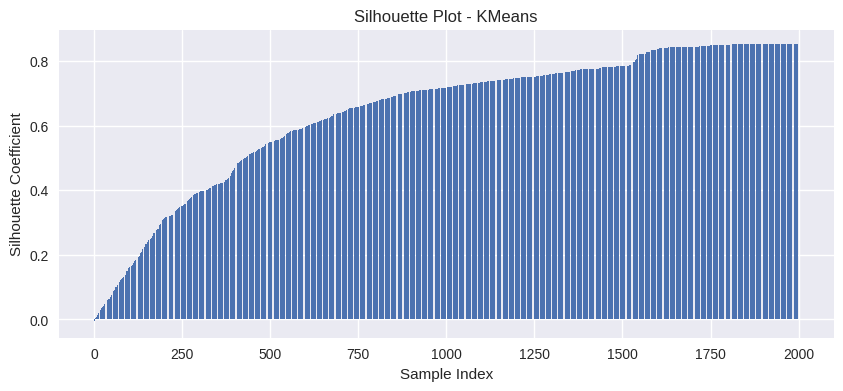

In [23]:
# Silhouette plot untuk KMeans
from sklearn.metrics import silhouette_samples

kmeans_labels = cluster_labels["KMeans"]
silhouette_vals = silhouette_samples(sample_data, kmeans_labels)
plt.figure(figsize=(10, 4))
plt.bar(range(len(silhouette_vals)), np.sort(silhouette_vals))
plt.title("Silhouette Plot - KMeans")
plt.xlabel("Sample Index")
plt.ylabel("Silhouette Coefficient")
plt.show()

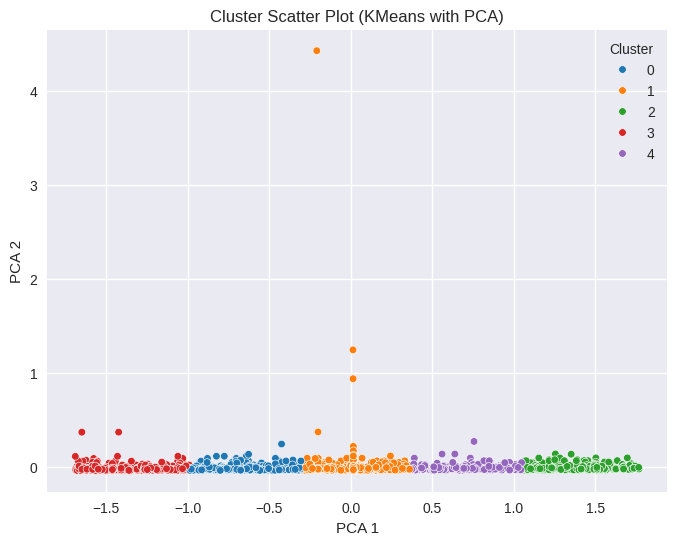

In [24]:
# PCA Scatter plot
pca = PCA(n_components=2)
pca_data = pca.fit_transform(sample_data)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], hue=kmeans_labels, palette='tab10', s=30)
plt.title("Cluster Scatter Plot (KMeans with PCA)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Cluster")
plt.show()

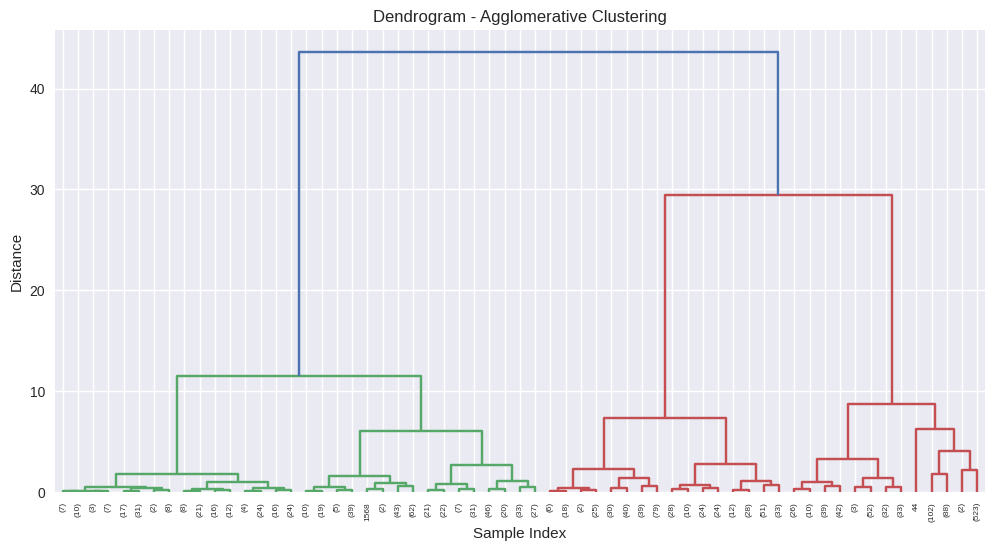

In [26]:
# Dendrogram untuk Agglomerative
from scipy.cluster.hierarchy import linkage, dendrogram

linked = linkage(sample_data, 'ward')
plt.figure(figsize=(12, 6))
dendrogram(linked, truncate_mode='level', p=5)
plt.title("Dendrogram - Agglomerative Clustering")
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.show()

###  Penjelasan Setiap Model

1. **KMeans**
   - Mengelompokkan data berdasarkan jarak ke pusat cluster.
   - Cocok untuk data berdistribusi **bulat dan terpisah jelas**.
   - Cepat dan efisien untuk dataset besar.
   - Tidak cocok untuk cluster non-linear atau berdensitas tidak merata.

2. **Agglomerative Clustering**
   - Pendekatan hierarkis (bottom-up).
   - Tidak perlu menentukan jumlah cluster sejak awal jika digunakan dengan dendrogram.
   - Cocok untuk data dengan bentuk cluster kompleks dan tidak bulat.

3. **DBSCAN (Density-Based Spatial Clustering of Applications with Noise)**
   - Mengelompokkan berdasarkan **kepadatan data**.
   - Cocok untuk data dengan **bentuk tidak beraturan**.
   - Dapat mengenali **outlier** atau **noise**.
   - Tidak membutuhkan jumlah cluster di awal, tetapi sensitif terhadap parameter `eps` dan `min_samples`.

4. **Gaussian Mixture Model (GMM)**
   - Probabilistik: setiap titik memiliki probabilitas terhadap semua cluster.
   - Cocok jika data berasal dari distribusi Gaussian berbeda.
   - Lebih fleksibel daripada KMeans dalam bentuk cluster (misalnya elips).

5. **Spectral Clustering**
   - Gunakan **graf matriks jarak** dan spektrum eigenvalue untuk membagi cluster.
   - Cocok untuk data non-linier dan kompleks.
   - Cenderung mahal secara komputasi untuk dataset besar.

---

###  Evaluasi Model: 3 Metrik Utama

| Metrik | Penjelasan | Semakin ... | Artinya |
|--------|------------|-------------|---------|
| **Silhouette Score** | Seberapa baik tiap titik cocok dengan clusternya dibanding cluster lain. | Mendekati **1** | Pemisahan cluster bagus |
| **Davies-Bouldin Index** | Rata-rata rasio jarak intra/inter-cluster. | Mendekati **0** | Cluster terpisah dengan baik |
| **Calinski-Harabasz Score** | Rasio antara varian antar-cluster dan intra-cluster. | Semakin **tinggi** | Cluster terpisah dan kompak |

---


###  Ringkasan Hasil Evaluasi

| Model              | Silhouette ↑ | Davies-Bouldin ↓ | Calinski-Harabasz ↑ |
|--------------------|--------------|------------------|----------------------|
| **KMeans**         | **0.641478** | **0.456393**     | **9188.13**          |
| Agglomerative      | 0.566691     | 0.509692         | 7018.75              |
| DBSCAN             | 0.593548     | 0.980473         | 18.512               |
| Gaussian Mixture   | -0.005761    | 9.84789          | 208.249              |
| Spectral Clustering| -0.0267238   | 0.78331          | 772.014              |

---

###  Model Terbaik: **KMeans**

**Alasannya:**

-  **Silhouette Score tertinggi (0.641)** → cluster sangat terpisah dengan baik.
-  **Davies-Bouldin Index terendah (0.456)** → cluster sangat kompak dan berbeda satu sama lain.
-  **Calinski-Harabasz Score tertinggi (9188.13)** → distribusi antar cluster sangat jelas.

Model lain seperti Agglomerative dan DBSCAN cukup bagus, tapi masih kurang konsisten pada ketiga metrik ini.


### **1. Jika algoritma K-Means menghasilkan nilai silhouette score rendah (0.3) meskipun elbow method menunjukkan K=5 sebagai optimal pada dataset ini, faktor apa yang menyebabkan inkonsistensi ini? Bagaimana strategi validasi alternatif (misal: analisis gap statistic atau validasi stabilitas cluster via bootstrapping) dapat mengatasi masalah ini, dan mengapa distribusi data non-spherical menjadi akar masalahnya?**

#### 🔹 **Penyebab Inkonsistensi:**
- **Elbow method** mengukur *total within-cluster SSE* (inertia), bukan kualitas pemisahan antar-cluster.
- Jika data **tidak berbentuk spherical**, Elbow bisa menilai salah jumlah cluster karena hanya fokus pada jarak ke centroid.
- **Silhouette score rendah (0.3)** berarti banyak titik lebih dekat ke cluster lain → pemisahan tidak tegas.

#### 🔹 **Strategi Validasi Alternatif:**
- **Gap Statistic** membandingkan inertia terhadap data acak. Jika jarak cluster lebih kecil dari ekspektasi acak, berarti struktur cluster kurang signifikan.
- **Bootstrapping cluster stability**: Evaluasi apakah struktur cluster konsisten saat sampling ulang.
- Keduanya menilai **robustness dan signifikansi statistik**, bukan hanya geometri.

#### 🔹 **Distribusi Non-Spherical sebagai Akar Masalah:**
- KMeans mengasumsikan bentuk cluster **bulat** dan berukuran **seragam**.
- Jika cluster elips, melengkung, atau berdensitas berbeda → KMeans keliru memisah.
---

### **2. Dalam dataset dengan campuran fitur numerik (Quantity, UnitPrice) dan kategorikal high-cardinality (Description), metode preprocessing apa yang efektif untuk menyelaraskan skala dan merepresentasikan fitur teks sebelum clustering? Jelaskan risiko menggunakan One-Hot Encoding untuk Description, dan mengapa teknik seperti TF-IDF atau embedding berdimensi rendah (UMAP) lebih robust untuk mempertahankan struktur cluster!**

#### 🔹 **Resiko dengan One-Hot Encoding:**
- **Sangat sparse** jika ada ribuan deskripsi produk → dimensi besar, computationally heavy.
- Tidak menangkap **kemiripan semantik** antar kata (misal: "red dress" vs. "dress red").

#### 🔹 **TF-IDF dan UMAP**
- **TF-IDF Vectorization**: Menangkap pentingnya kata per dokumen, meredam dominasi kata umum.
- **UMAP** (Uniform Manifold Approximation and Projection):
  - Reduksi dimensi TF-IDF (misal dari 10.000 jadi 10-50).
  - Menjaga struktur manifold → membantu pelestarian relasi semantik.
- **Word Embeddings (Word2Vec / BERT)** + pooling: Vektorisasi berdasarkan makna.

#### 🔹 **Untuk fitur numerik** seperti Quantity/UnitPrice:
- Gunakan **StandardScaler** agar sebanding dengan hasil TF-IDF/UMAP.
- Atau **Pipeline** untuk menggabungkan preprocessing numerik dan teks via `ColumnTransformer`.

---

### **3. Hasil clustering dengan DBSCAN sangat sensitif terhadap parameter epsilon—bagaimana menentukan nilai optimal epsilon secara adaptif untuk memisahkan cluster padat dari noise pada data transaksi yang tidak seimbang (misal: 90% pelanggan dari UK)? Jelaskan peran k-distance graph dan kuartil ke-3 dalam automasi parameter, serta mengapa MinPts harus disesuaikan berdasarkan kerapatan regional!**

#### 🔹 **Masalah:**
- Transaksi tidak merata (UK dominan → padat; negara lain → sparse).
- Epsilon terlalu kecil → split berlebihan; terlalu besar → cluster overlap.

#### 🔹 **Solusi Adaptif:**
- **k-Distance Graph**:
  - Untuk setiap titik, hitung jarak ke tetangga ke-k (misal k = MinPts).
  - Plot jarak tersebut secara menurun → cari “elbow” (titik perubahan tajam).
- **Kuartil ke-3 (Q3)**:
  - Pilih epsilon sebagai **Q3** dari k-distance → mengabaikan noise ekstrim.

#### 🔹 **MinPts disesuaikan:**
- Heuristik: `MinPts = log(n)` atau `D+1` (D = dimensi data).
- Pada area padat, gunakan **adaptif MinPts per region** jika memungkinkan.

---

### **4. Jika analisis post-clustering mengungkapkan overlap signifikan antara cluster "high-value customers" dan "bulk buyers" berdasarkan total pengeluaran, bagaimana teknik semi-supervised (contoh: constrained clustering) atau integrasi metric learning (Mahalanobis distance) dapat memperbaiki pemisahan cluster? Jelaskan tantangan dalam mempertahankan interpretabilitas bisnis saat menggunakan pendekatan non-Euclidean!"**

#### 🔹 **Masalah:**
- Keduanya memiliki *Total Spend* tinggi, tetapi berbeda motivasi → bisa overlap dalam vektor fitur.
- KMeans tidak bisa membedakan konteks transaksi → perlu tambahan pengetahuan.

#### 🔹 **Solusi:**
- **Constrained Clustering (Semi-Supervised)**:
  - Contoh: **COP-KMeans** dengan *must-link* dan *cannot-link* constraints.
  - Tambahkan domain knowledge secara eksplisit.
- **Metric Learning (e.g. Mahalanobis Distance)**:
  - Pelajari metrik yang memaksimalkan jarak antar label known class.
  - Bantu pemisahan *overlapping cluster* berdasarkan fitur relevan.

#### 🔹 **Tantangan Interpretabilitas:**
- Mahalanobis atau embedding → hasil tidak sebanding secara langsung dengan fitur asli.
- Kurang cocok jika *stakeholder bisnis* butuh penjelasan berbasis metrik asli seperti *UnitPrice* atau *Quantity*.

✅ Solusi: dokumentasikan transformasi, dan gunakan teknik seperti **LIME** untuk interpretasi lokal jika perlu.

---

### **5. Bagaimana merancang temporal features dari InvoiceDate (misal: hari dalam seminggu, jam pembelian) untuk mengidentifikasi pola pembelian periodik (seperti transaksi pagi vs. malam)? Jelaskan risiko data leakage jika menggunakan agregasi temporal (misal: rata-rata pembelian bulanan) tanpa time-based cross-validation, dan mengapa lag features (pembelian 7 hari sebelumnya) dapat memperkenalkan noise pada cluster!**

#### 🔹 **Fitur Temporal Potensial:**
- Hari dalam minggu (`InvoiceDate.dt.dayofweek`)
- Jam pembelian (`InvoiceDate.dt.hour`)
- Kategori waktu: pagi/siang/malam
- *Seasonality*: apakah pembelian meningkat saat akhir bulan/minggu?

#### 🔹 **Risiko Data Leakage:**
- Jika membuat agregasi **berbasis seluruh dataset** (misal: *mean bulanan*) → informasi dari masa depan bisa bocor ke masa lalu.
- **Solusi**: Gunakan **time-based cross-validation** atau sliding window saat training.

#### 🔹 **Masalah Lag Features:**
- Lag 7 hari (`pembelian 7 hari lalu`) bisa tidak relevan jika user belanja tidak rutin.
- Bisa menciptakan **noise** pada cluster → model menangkap pola acak.

Gunakan lag hanya jika ada bukti **konsistensi periodik** (misal: weekly shopping behavior).

